In [16]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import torch.nn as nn
from torchvision.transforms import v2
import multiprocessing
import torch.quantization
import torch.optim as optim

In [9]:
# run variables

seed = 42

In [ ]:
# device settings

num_workers = multiprocessing.cpu_count() // 2

# print(torch.cuda.get_device_name(torch.cuda.current_device()))

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [72]:
# define datasets and loaders

transform = v2.Compose([
    v2.ToTensor(),  # Converts image to Tensor and scales to [0, 1]
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CIFAR10("./../data", train=True, transform=transform, download=True)
test_dataset = CIFAR10("./../data", train=False, transform=transform, download=True)

train_dataset, validation_dataset =  random_split(train_dataset, [0.8, 0.2])

print('train set size:', len(train_dataset))
print('validation set size:', len(validation_dataset))
print('test set size:', len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=num_workers)
validation_loader = DataLoader(validation_dataset, batch_size=128, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=num_workers)

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

c:\Users\barte\miniconda3\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


train set size: 40000
validation set size: 10000
test set size: 10000


In [97]:
class BaseNN(nn.Module):
    def __init__(self, num_classes=10):
        super(BaseNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.features(x)
        x = x.reshape(x.size(0), -1)
        x = self.classifier(x)
        x = self.dequant(x)
        return x

In [98]:
torch.manual_seed(seed)
model = BaseNN(num_classes=10).to(device)

In [100]:
def train(model, epochs, learning_rate):
    trainingEpoch_loss = []
    validationEpoch_loss = []
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    qat_started = False  # Flaga do śledzenia momentu rozpoczęcia QAT

    for epoch in range(epochs):
        model.train()

        # Jeśli minęły 2 epoki i QAT jeszcze się nie rozpoczął
        if epoch == 2 and not qat_started:
            print("Rozpoczynanie Quantization-Aware Training (QAT)...")
            model.qconfig = torch.quantization.get_default_qat_qconfig("fbgemm")
            torch.quantization.prepare_qat(model, inplace=True)
            qat_started = True

        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            logits = outputs[0] if isinstance(outputs, tuple) else outputs
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        trainingEpoch_loss.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}")

        # Ewaluacja
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                logits = outputs[0] if isinstance(outputs, tuple) else outputs
                loss = criterion(logits, labels)

                validation_loss += loss.item()

        avg_val_loss = validation_loss / len(validation_loader)
        validationEpoch_loss.append(avg_val_loss)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}")

    return trainingEpoch_loss, validationEpoch_loss

In [101]:
def test(model):
    correct = 0
    total = 0

    model.eval()  
    
    with torch.no_grad():  
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  

            outputs = model(inputs)

            logits = outputs[0] if isinstance(outputs, tuple) else outputs

            _, predicted = torch.max(logits.data, 1)  

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [102]:
trainingEpoch_loss, validationEpoch_loss = train(model, epochs=5, learning_rate=0.0001)

Epoch 1/5, Training Loss: 1.4122
Epoch 1/5, Validation Loss: 1.1830
Epoch 2/5, Training Loss: 1.0041
Epoch 2/5, Validation Loss: 0.9342
Rozpoczynanie Quantization-Aware Training (QAT)...


c:\Users\barte\miniconda3\Lib\site-packages\torch\ao\quantization\observer.py:244: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Epoch 3/5, Training Loss: 0.8591
Epoch 3/5, Validation Loss: 0.9059
Epoch 4/5, Training Loss: 0.7751
Epoch 4/5, Validation Loss: 0.8463
Epoch 5/5, Training Loss: 0.7072
Epoch 5/5, Validation Loss: 0.7635


In [103]:
model = torch.quantization.convert(model, inplace=True) 

In [105]:
test(model)

Test Accuracy: 73.34%


73.34

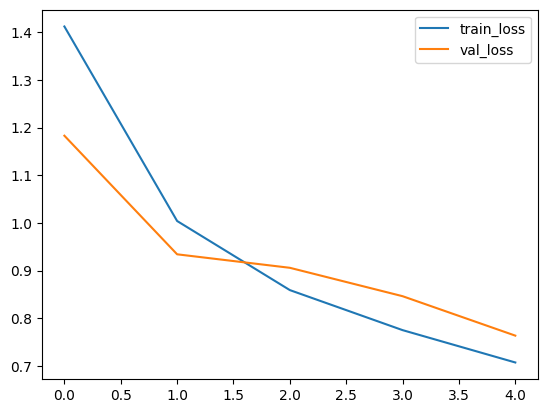

In [104]:
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
# plt.ylim(top=2)
plt.show()